In [1]:
# Importamos funciones y establecemos configuración general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api as sm
import warnings
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.x13 import x13_arima_analysis
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = [10,4] 
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 50)
pd.set_option('display.max_columns', 30)

In [2]:
# Generamos funciones que vamos a usar en el notebook
def DFtest(datos):
    print('Results of Dickey-Fuller Test (H0= NO estac.):')
    dftest = adfuller(datos, autolag='AIC')
    print('Test Statistic', dftest[0])
    print('p-value', dftest[1])
    print('#Lags Used', dftest[2])
    print('# obs', dftest[3])
    for k, v in dftest[4].items():
        print(k,v)

def mape(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    print({'mape':mape})
    
def corr(forecast, actual):
    corr = np.corrcoef(forecast, actual)[0,1]
    print({'corr':corr})

In [3]:
file="C:/Users/jjime/OneDrive/Escritorio/3ro GANE/Coyuntura/Informes/Informe 2"

# Parte 1: Desestacionalización del PIB

In [4]:
#Importamos datos
pib=pd.read_excel("pib.xlsx")

#Corregimos nombres de las variables y añadimos índice
pib.columns=["fecha","ocupados", "pib_ministerio", "pib"]
pib.fecha=pib.fecha.astype(str)
pib['fecha'] = pib['fecha'].str[:4] + "Q" + pib['fecha'].str[-1:]
pib['fecha'] = pd.to_datetime(pib['fecha'])
pib.set_index('fecha', inplace=True)
pib

,ocupados,pib_ministerio,pib
fecha,,,
2000-01-01,15119.3,79.788770,77.637248
2000-04-01,15440.2,80.792916,81.737319
2000-07-01,15681.8,81.665226,80.100458
2000-10-01,15782.3,82.497064,85.268951
2001-01-01,15866.3,83.377185,80.995321
...,...,...,...
2022-04-01,20468.0,110.895222,111.524439
2022-07-01,20545.7,111.483513,111.148133
2022-10-01,20463.9,112.031186,114.768832


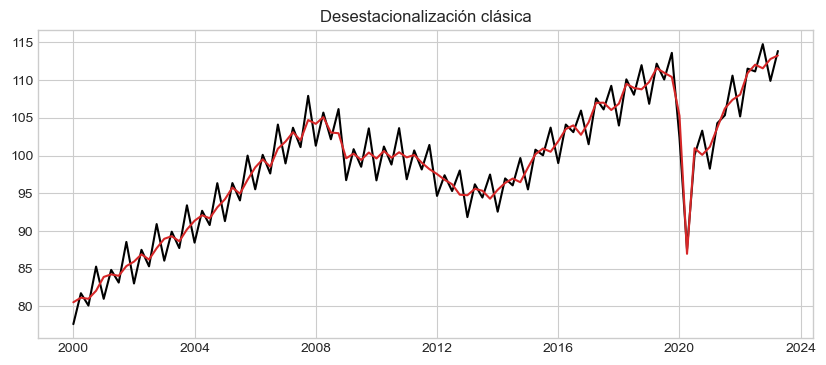

{'mape': 0.0048790242757618865}


In [5]:
#Descomposición clásica aditiva:
ad=seasonal_decompose(pib.pib, model="additive", period=4)
pib_ad=pib.pib-ad.seasonal

#Análisis Gráfico:
fig,ax=plt.subplots()
ax.plot(pib.pib,c="black")
ax.plot(pib_ad,c="tab:red")
ax.set_title("Desestacionalización clásica")
plt.show()

#Error medio:
mape(pib_ad, pib.pib_ministerio)

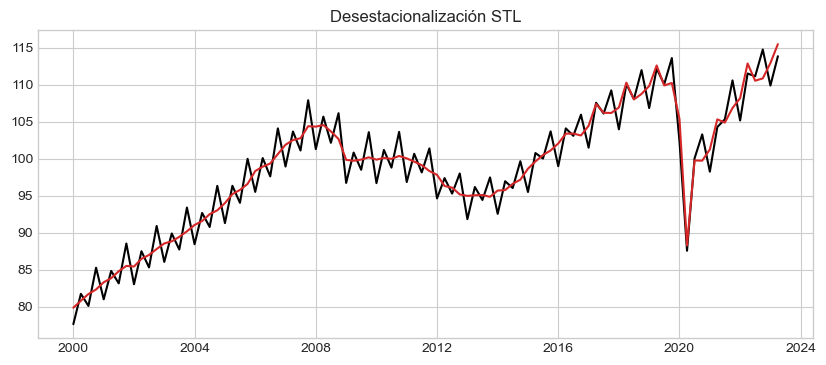

{'mape': 0.0038765965107938768}


In [6]:
# Descomposición STL
stl = STL(pib.pib,seasonal=13, period=4).fit()
pib_stl=pib.pib-stl.seasonal

#Análisis Gráfico:
fig,ax=plt.subplots()
ax.plot(pib.pib,c="black")
ax.plot(pib_stl,c="tab:red")
ax.set_title("Desestacionalización STL")
plt.show()

#Error medio:
mape(pib_stl, pib.pib_ministerio)

In [7]:
# Descomposición x13-ARIMA-SEATS
X13PATH = r"C:\WinX13\x13as\x13as.exe"
x13 = x13_arima_analysis(endog=pib.pib, x12path=X13PATH, trading=True)
pib_x13 = x13.seasadj

#Análisis Gráfico:
fig,ax=plt.subplots()
ax.plot(pib.pib,c="black")
ax.plot(pib_x13,c="tab:red")
ax.set_title("Desestacionalización STL")
plt.show()

#Error medio:
map1=mape(pib_x13, pib.pib_ministerio)

X13NotFoundError: x12a and x13as not found on path. Give the path, put them on PATH, or set the X12PATH or X13PATH environmental variable.

In [ ]:
#El método que más se aproxima a la serie corregida por estacionalidad del PIB es el X13 ARIMA, obteniendo un coeficiente mape igual a 0,002.

# PARTE 2: MODELIZACIÓN ARIMA

In [8]:
#Definimos la serie en dos partes:
train=pib.loc[:"2020-10"]#Nos recoge la evolución de la serie
test=pib.loc["2021-01":]#Nos sirve para corroborar los datos estimados del modelo 

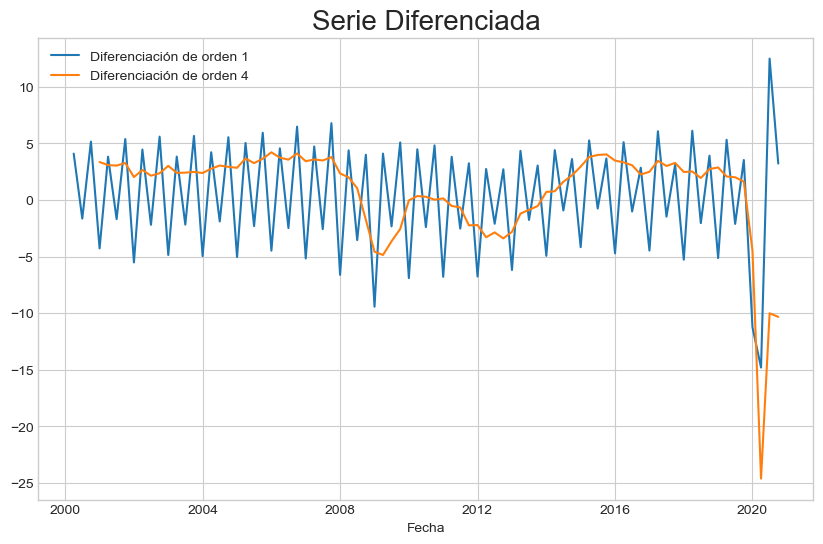

In [9]:
plt.figure(figsize=(10, 6))

# Graficar la serie diferenciada con un retraso de 1 y 4
plt.plot(train.pib.diff(1), label="Diferenciación de orden 1")
plt.plot(train.pib.diff(4), label="Diferenciación de orden 4")

# Agregar etiquetas y título
plt.title("Serie Diferenciada", fontsize=20)
plt.xlabel("Fecha")
plt.legend()

# Mostrar el gráfico
plt.show()

In [10]:
train.pib.diff(4)

fecha
2000-01-01          NaN
2000-04-01          NaN
2000-07-01          NaN
2000-10-01          NaN
2001-01-01     3.358073
                ...    
2019-10-01     1.633025
2020-01-01    -4.485959
2020-04-01   -24.622659
2020-07-01   -10.008734
2020-10-01   -10.322883
Name: pib, Length: 84, dtype: float64

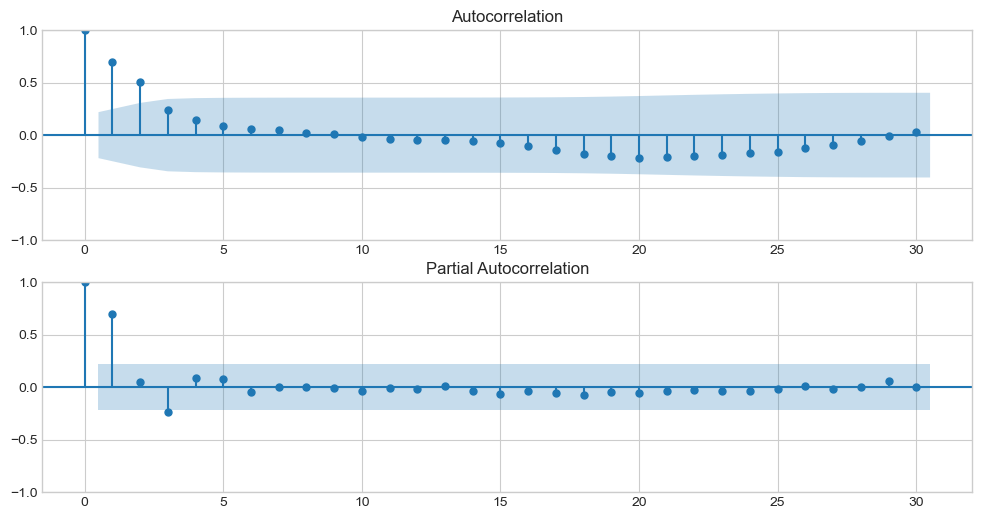

Results of Dickey-Fuller Test (H0= NO estac.):
Test Statistic -2.888561632891749
p-value 0.04669438402016441
#Lags Used 0
# obs 79
1% -3.5159766913976376
5% -2.898885703483903
10% -2.5866935058484217


In [11]:
#Dibujamos correlogramas y analizamos la estacionariedad de la serie
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train.pib.diff(4).dropna(), ax=ax[0], lags=30)
ax[1] = plot_pacf(train.pib.diff(4).dropna(), ax=ax[1], lags=30)
plt.show()
DFtest(train.pib.diff(4).dropna())

# PARTE 2.1: MODELO 1-> ARIMA(0,1,1)x(0,1,0,4) 

                                     SARIMAX Results                                      
Dep. Variable:                                pib   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 4)   Log Likelihood                -191.685
Date:                            Tue, 28 Nov 2023   AIC                            389.371
Time:                                    09:31:49   BIC                            396.402
Sample:                                01-01-2000   HQIC                           392.183
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1828      0.590     -0.310      0.757      -1.339       0.974
ma.L1         -0.3117      0.060   

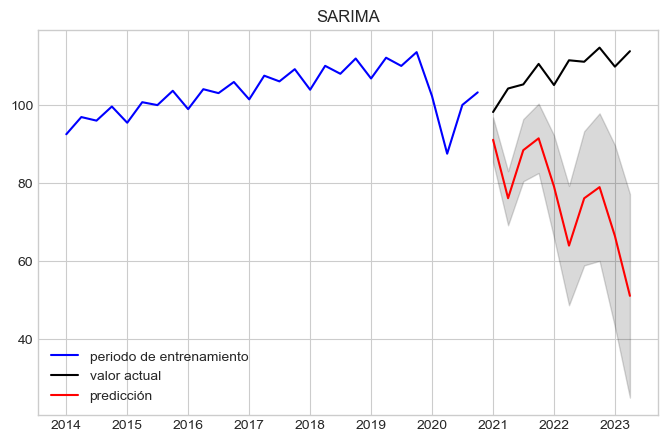

In [12]:
#Estimamos y predecimos el modelo
mod1=sm.tsa.statespace.SARIMAX(train.pib,order=(0,1,1), seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(mod1.summary())
pred1=mod1.get_prediction('2021-01-01','2023-04-01')

print("                                           ")

#Hallamos el error medio:
mape(pred1.predicted_mean, test.pib_ministerio)

# Dibujamos la predicción:
pred_ci1 = pred1.conf_int()

# Creando las series para su representación gráfica
pred1 = pd.Series(pred1.predicted_mean, index=test.index)
lower_ci1 = pd.Series(pred_ci1["lower pib"], index=test.index)
upper_ci1 = pd.Series(pred_ci1["upper pib"], index=test.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(train.pib.loc["2014-01-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test.pib, label="valor actual", color="black")
ax.plot(pred1, label="predicción", color='r')
ax.fill_between(lower_ci1.index,
                 lower_ci1,
                 upper_ci1,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

# PARTE 2.2: MODELO 2-> ARIMA(2,1,1) 

In [ ]:
#Estimamos y predecimos el modelo
mod2=sm.tsa.statespace.SARIMAX(train.pib,order=(2,1,1), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(mod2.summary())
pred2=mod2.get_prediction('2021-01-01','2023-04-01')

print("                                           ")

#Hallamos el error medio:
mape(pred2.predicted_mean, test.pib_ministerio)

# Dibujamos la predicción:
pred_ci2 = pred2.conf_int()

# Creando las series para su representación gráfica
pred2 = pd.Series(pred2.predicted_mean, index=test.index)
lower_ci2 = pd.Series(pred_ci2["lower pib"], index=test.index)
upper_ci2 = pd.Series(pred_ci2["upper pib"], index=test.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(train.pib, label="periodo de entrenamiento", color="blue")
ax.plot(test.pib, label="valor actual", color="black")
ax.plot(pred2, label="prediccion", color='r')
ax.fill_between(lower_ci2.index,
                 lower_ci2,
                 upper_ci2,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

# PARTE 2.3: Modelo Automático No Estacional

In [ ]:
mod3 = pm.auto_arima(train.pib, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    seasonal=False,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

In [ ]:
#Estimamos y predecimos el modelo
mod3=sm.tsa.statespace.SARIMAX(train.pib,order=(3,1,2),trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(mod3.summary())
pred3=mod3.get_prediction('2021-01-01','2023-04-01')

print("                                           ")

#Hallamos el error medio:
mape(pred3.predicted_mean, test.pib_ministerio)

# Dibujamos la predicción:
pred_ci3 = pred3.conf_int()

# Creando las series para su representación gráfica
pred3 = pd.Series(pred3.predicted_mean, index=test.index)
lower_ci3 = pd.Series(pred_ci3["lower pib"], index=test.index)
upper_ci3 = pd.Series(pred_ci3["upper pib"], index=test.index)

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(train.pib, label="periodo de entrenamiento", color="blue")
ax.plot(test.pib, label="valor actual", color="black")
ax.plot(pred3, label="predicción", color='r')
ax.fill_between(lower_ci3.index,
                 lower_ci3,
                 upper_ci3,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

# PARTE 2.4: Modelo Automático Estacional

In [17]:
mod4 = pm.auto_arima(train.pib, start_p=0, start_d=0, start_q=0,
                    max_p=3, max_d=1, max_q=3, 
                    start_P=0, start_D=0, start_Q=0,
                    max_P=3, max_D=1, max_Q=3,m=4, 
                    seasonal=True,test='adf',
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=False)

 ARIMA(0,1,0)(0,1,0)[4]             : AIC=399.348, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=401.279, Time=0.02 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=403.241, Time=0.03 sec
 ARIMA(0,1,0)(0,1,3)[4]             : AIC=404.475, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=401.292, Time=0.02 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=402.990, Time=0.05 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=404.734, Time=0.07 sec
 ARIMA(0,1,0)(1,1,3)[4]             : AIC=406.461, Time=0.07 sec
 ARIMA(0,1,0)(2,1,0)[4]             : AIC=403.187, Time=0.03 sec
 ARIMA(0,1,0)(2,1,1)[4]             : AIC=404.639, Time=0.06 sec
 ARIMA(0,1,0)(2,1,2)[4]             : AIC=406.713, Time=0.15 sec
 ARIMA(0,1,0)(2,1,3)[4]             : AIC=408.116, Time=0.27 sec
 ARIMA(0,1,0)(3,1,0)[4]             : AIC=404.712, Time=0.03 sec
 ARIMA(0,1,0)(3,1,1)[4]             : AIC=406.575, Time=0.11 sec
 ARIMA(0,1,0)(3,1,2)[4]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,1,0)[4]      

Mismo Modelo que el inicial. Por lo tanto, el mejor modelo es: SARIMA(0,1,1)x(0,1,0,4). Aunque su error de predicción no sea el mínimo pues arrastra el shock del covid por la proximidad de la train database a dicha fecha. 

# PARTE 2.5: Predicción Futura

                                     SARIMAX Results                                      
Dep. Variable:                                pib   No. Observations:                   94
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 4)   Log Likelihood                -239.692
Date:                            Tue, 28 Nov 2023   AIC                            485.383
Time:                                    09:34:53   BIC                            492.781
Sample:                                01-01-2000   HQIC                           488.362
                                     - 04-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0023      0.315     -0.007      0.994      -0.619       0.615
ma.L1         -0.2328      0.049   

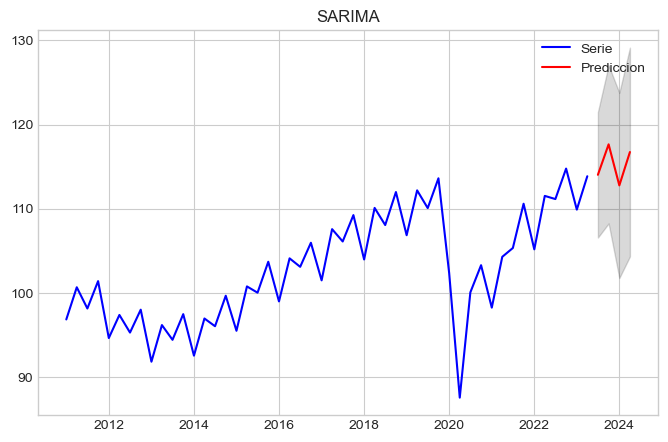

In [15]:
#Estimamos y predecimos el modelo
modf=sm.tsa.statespace.SARIMAX(pib.pib,order=(0,1,1), seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()


print(modf.summary())
predf=modf.get_prediction('2023-07-01','2024-04-01')

print("                                           ")

# Dibujamos la predicción:
pred_cif = predf.conf_int()
pred_cif.columns=["bajo", "alto"]

# Creando las series para su representación gráfica
bajof=pd.Series(pred_cif["bajo"])
altof = pd.Series(pred_cif["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
#Para que se pueda observar mejor en el informe
ax.plot(pib.pib.loc["2014-01-01":], label="Serie", color="blue") 
ax.plot(predf.predicted_mean, label="Prediccion", color='r')
ax.fill_between(bajof.index,
                 bajof,
                 altof,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA")
plt.show()

# PARTE 3: MODELIZACIÓN SARIMAX

In [18]:
#Impoprtamos variables resto exógenas:
exogm=pd.read_excel("exog.xlsx")
exogm.columns=["periodo","actividad","cons_elec","cons_gaso","matri_tur","ivgs"]

#Pasar meses a indice:
exogm['periodo'] = pd.to_datetime(exogm['periodo'], format='%Y%m')
exogm.set_index('periodo', inplace=True)
exogm.index=exogm.index.to_period("M")
exogq=exogm.resample("Q", label="right").mean()
exogq.index=exogq.index.to_timestamp()
exogq

,actividad,cons_elec,cons_gaso,matri_tur,ivgs
periodo,,,,,
2000-01-01,81.412873,16648.461710,662.056667,129236.000000,106.355667
2000-04-01,82.525665,15619.955653,713.243333,139565.666667,107.452333
2000-07-01,83.082118,16070.384087,787.656667,113551.333333,109.103000
2000-10-01,83.987316,16677.958180,652.266667,106148.000000,108.791667
2001-01-01,84.489646,17348.196370,643.566667,126304.666667,110.707000
...,...,...,...,...,...
2022-07-01,115.464340,20529.284743,531.956667,73202.000000,106.923000
2022-10-01,116.198134,18496.113910,486.540000,78967.666667,108.821333
2023-01-01,116.962202,19811.631973,438.713333,86884.333333,110.674333


                                     SARIMAX Results                                      
Dep. Variable:                                pib   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 4)   Log Likelihood                 -82.359
Date:                            Tue, 28 Nov 2023   AIC                            182.719
Time:                                    09:41:52   BIC                            203.813
Sample:                                01-01-2000   HQIC                           191.156
                                     - 10-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0279      0.071     -0.393      0.695      -0.167       0.111
ocupados       0.0016      0.001   

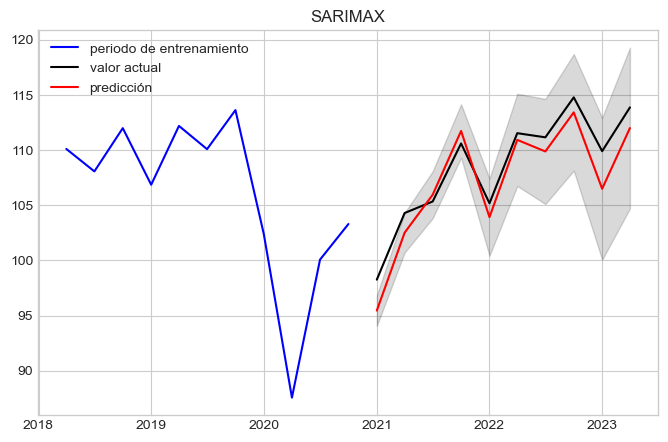

In [19]:
#Definimos trainis y test para las nuveas variables:
exogq_train=exogq.loc[:"2020-10"]
exogq_test=exogq.loc["2021-01":"2023-04"]
#Interesante solo una variable exógena: isa (indice que se crea a partir de otros)
x=pd.concat([pib.ocupados, exogq.actividad, exogq.cons_elec, exogq.cons_gaso, exogq.matri_tur, exogq.ivgs], axis=1)
x_train=pd.concat([train.ocupados, exogq_train.actividad, exogq_train.cons_elec, exogq_train.cons_gaso, exogq_train.matri_tur, exogq_train.ivgs], axis=1)
x_test=pd.concat([test.ocupados, exogq_test.actividad, exogq_test.cons_elec, exogq_test.cons_gaso, exogq_test.matri_tur, exogq_test.ivgs], axis=1)

#Estimamos y predecimos el modelo
modx=sm.tsa.statespace.SARIMAX(train.pib,  exog=x_train, order=(0,1,1),seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modx.summary())
exogq_test = exogq_test.loc['2021-01':'2023-04']
predx = modx.get_prediction('2021-01', '2023-04', exog=x_test)

#Hallamos el error medio de la nueva predicción:
mape(predx.predicted_mean, pib.pib_ministerio)

print("                                           ")

# Dibujamos la predicción:
pred_cix = predx.conf_int()
pred_cix.columns=["bajo", "alto"]

# Creando las series para su representación gráfica
bajox=pd.Series(pred_cix["bajo"])
altox = pd.Series(pred_cix["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(train.pib.loc["2018-04-01":], label="periodo de entrenamiento", color="blue")
ax.plot(test.pib, label="valor actual", color="black")
ax.plot(predx.predicted_mean, label="predicción", color='r')
ax.fill_between(bajox.index,
                 bajox,
                 altox,
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMAX")
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                                pib   No. Observations:                   94
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 4)   Log Likelihood                -107.692
Date:                            Tue, 28 Nov 2023   AIC                            233.384
Time:                                    09:47:33   BIC                            255.577
Sample:                                01-01-2000   HQIC                           242.321
                                     - 04-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0042      0.092     -0.045      0.964      -0.184       0.175
ocupados       0.0012      0.001   

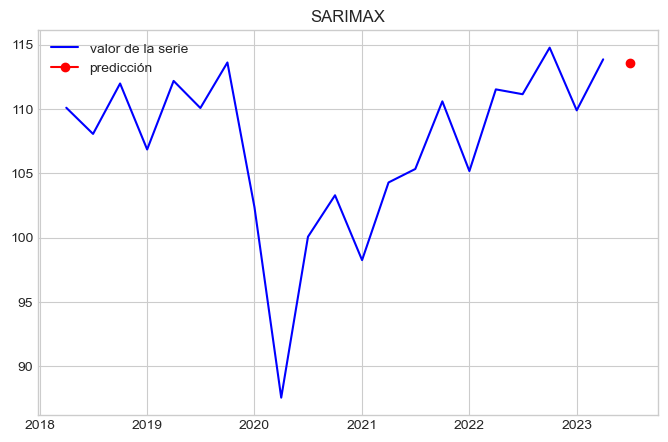

In [20]:
#Estimamos y predecimos el modelo
modxf=sm.tsa.statespace.SARIMAX(pib.pib,  exog=x.loc[:"2023-04"], order=(0,1,1),seasonal_order=(0,1,0,4), trend="c",
                                enforce_stationarity=False, enforce_invertibility=False).fit()

print(modxf.summary())

#Predecimos el valor de ocupados en el tercer trimestre para evitar valores nulos:
x.ocupados['2023-07']=20769.5

predxf = modxf.get_prediction('2023-07', exog=x.loc['2023-07':])

print("                                           ")


# Creando las series para su representación gráfica
bajox=pd.Series(pred_cix["bajo"])
altox = pd.Series(pred_cix["alto"])

# Gráfico
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(pib.pib.loc["2018-04-01":], label="valor de la serie", color="blue")
ax.plot(predxf.predicted_mean, label="predicción", marker='o', color='r')
ax.legend()
ax.set_title("SARIMAX")
plt.show()

In [21]:
print('El valor del pib en indice de volumenes encadenado para el tercer trimestre de este año es : ', predxf.predicted_mean.values[0])

El valor del pib en indice de volumenes encadenado para el tercer trimestre de este año es :  113.59875120016481


In [ ]:
forecast=predxf.predicted_mean.values[0]-pib.pib['2022-07']
print("La tasa de varaiación anual es de un: ", forecast.values[0], "%")

# PRESENTACIÓN FINAL:

In [ ]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(3,2,figsize=(8.27,11.69)) # Una hoja A4 tiene ese tamaño, en pulgadas.

# Borro todos los ejes de los dos gráficos superiores
ax1.axis('off')
ax2.axis('off')

# Encabezado
fig.text(0.1,0.85,"INFORME 2", weight="bold", size=15)
fig.text(0.1,0.82,"DESESTACIONALIZACIÓN Y MODELIZACIÓN DEL PIB", weight="bold", size=14)
fig.text(0.1,0.79,"Jiménez Vragas, Jesús", size=12)
fig.text(0.1,0.77,"Fecha: Noviembre de 2023", size=12)

# Parte 1:
fig.text(0.1,0.72,"PARTE 1: DESESTACIONALIZACIÓN DEL PIB", weight="bold", size=13)
fig.text(0.1,0.67,"El método que más se aproxima a la serie corregida por estacionalidad del PIB es el\n\
X13 ARIMA Seats, obteniendo un coeficiente mape igual a 0,002", size=12)

# Parte 2
#Gráfico con el análisis del modelo elegido:
fig.text(0.1,0.62,"PARTE 2: PREDICCIÓN SARIMA (0,1,1) (0,1,0,4)", weight="bold", size=13)
ax3.plot(train.pib.loc["2015-01-01":], label="serie", color="blue")
ax3.plot(test.pib, label="valor actual", color="black")
ax3.plot(pred1, label="predicción", color='r')
ax3.fill_between(lower_ci1.index,
                 lower_ci1,
                 upper_ci1,
                 color='k', alpha=.15)
ax3.legend()
ax3.text(0.6,0.25,"AIC=389.371",transform=ax3.transAxes)
ax3.text(0.6,0.15,"mape=0.294",transform=ax3.transAxes)

#Gráfico con predicción futura:
ax4.plot(pib.pib.loc["2015-01-01":], label="serie", color="blue") 
ax4.plot(predf.predicted_mean, label="Prediccion", color='r')
ax4.fill_between(bajof.index,
                 bajof,
                 altof,
                 color='k', alpha=.15)
ax4.legend()

# Parte 3:
#Gráfico con el análisis del modelo elegido junto con variables exógenas:
fig.text(0.1,0.33,"PARTE 3: PREDICCIÓN SARIMAX", weight="bold", size=13)
ax5.plot(train.pib.loc["2015-04-01":], label="serie", color="blue")
ax5.plot(test.pib, label="valor actual", color="black")
ax5.plot(predx.predicted_mean, label="predicción", color='r')
ax5.fill_between(bajox.index,
                 bajox,
                 altox,
                 color='k', alpha=.15)
ax5.legend()
ax5.text(0.73,0.25,"AIC=182.72",transform=ax5.transAxes)
ax5.text(0.73,0.15,"mape=0.024",transform=ax5.transAxes)

##Gráfico con predicción futura:
ax6.plot(pib.pib.loc["2018-04-01":], label="serie", color="blue")
ax6.plot(predxf.predicted_mean, label="predicción", marker='o', color='r')
ax6.legend()

fig.text(0.1,0.05,"Según nuestra estimación del modelo SARIMAX, la tasa de variación interanual del PIB\n\
para el tercer trimestre de 2023 será del 2.45%.", size=12)
plt.subplots_adjust(hspace=0.4)
plt.savefig("Informe2.pdf",  bbox_inches='tight', pad_inches=0.5, format="pdf")
plt.show()